# Part 1: Regression Task with NYSE Dataset
## Deep Learning Lab - PyTorch Implementation

**Objective**: Build a Deep Neural Network to predict stock prices using PyTorch

---

## Table of Contents
1. [Setup and Data Loading](#1-setup)
2. [Exploratory Data Analysis (EDA)](#2-eda)
3. [Data Preprocessing](#3-preprocessing)
4. [Build Deep Neural Network](#4-dnn)
5. [Hyperparameter Tuning with GridSearch](#5-gridsearch)
6. [Training and Visualization](#6-training)
7. [Regularization Techniques](#7-regularization)
8. [Comparison and Conclusions](#8-conclusions)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---
## 1. Setup and Data Loading <a id='1-setup'></a>

First, we'll import all necessary libraries and load the dataset.

In [ ]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision pandas numpy matplotlib seaborn scikit-learn

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully!
PyTorch Version: 2.9.0+cu126
Device: GPU


### Load the Dataset

**Note**: Download the NYSE dataset from [Kaggle](https://www.kaggle.com/datasets/dgawlik/nyse) first.

The dataset contains historical stock prices for various companies.

In [3]:
# Load the dataset
# If you're using Kaggle, the path might be different
# For Google Colab, upload the file first

# Example for local file:
df = pd.read_csv('prices.csv')

# For Google Colab (uncomment if needed):
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv('prices.csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Dataset loaded successfully!
Shape: (35532, 7)
Columns: ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']


---
## 2. Exploratory Data Analysis (EDA) <a id='2-eda'></a>

Let's explore the dataset to understand its structure and characteristics.

In [4]:
# Display first few rows
print("First 5 rows of the dataset:")
display(df.head())

print("\nLast 5 rows:")
display(df.tail())

First 5 rows of the dataset:


,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0



Last 5 rows:


,date,symbol,open,close,low,high,volume
35527,2010-04-22,FOX,18.320005,18.519995,18.040005,18.530003,4792300.0
35528,2010-04-22,FOXA,15.919994,16.060000,15.629999,16.099995,21267200.0
35529,2010-04-22,FRT,75.370003,77.830002,75.150002,78.010002,492100.0
35530,2010-04-22,FSLR,129.500000,133.940002,129.360001,134.289993,1493200.0
35531,2010-04-22,FTI,66.040001,68.000000,NaN,NaN,NaN


In [5]:
# Basic information about the dataset
print("Dataset Information:")
print(df.info())

print("\n" + "="*50)
print("Statistical Summary:")
display(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35532 entries, 0 to 35531
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    35532 non-null  object 
 1   symbol  35532 non-null  object 
 2   open    35532 non-null  float64
 3   close   35532 non-null  float64
 4   low     35531 non-null  float64
 5   high    35531 non-null  float64
 6   volume  35531 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.9+ MB
None

Statistical Summary:


,open,close,low,high,volume
count,35532.000000,35532.000000,35531.000000,35531.000000,3.553100e+04
mean,47.615043,47.667472,47.103553,48.126793,7.287973e+06
std,48.597344,48.594836,48.086776,49.078011,1.743004e+07
min,1.260000,1.270000,1.240000,1.300000,0.000000e+00
25%,25.030001,25.040001,24.750000,25.299999,1.481950e+06
50%,38.299999,38.310001,37.910000,38.700001,3.133500e+06
75%,55.892503,55.980000,55.360079,56.490002,6.668300e+06
max,627.181073,626.751061,624.241073,629.511067,5.890618e+08


In [6]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_percent
})
display(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("\n✓ No missing values found!")

Missing Values:


,Missing Count,Percentage
low,1,0.002814
high,1,0.002814
volume,1,0.002814


In [7]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates/len(df))*100:.2f}%")

Number of duplicate rows: 0


### Visualizations

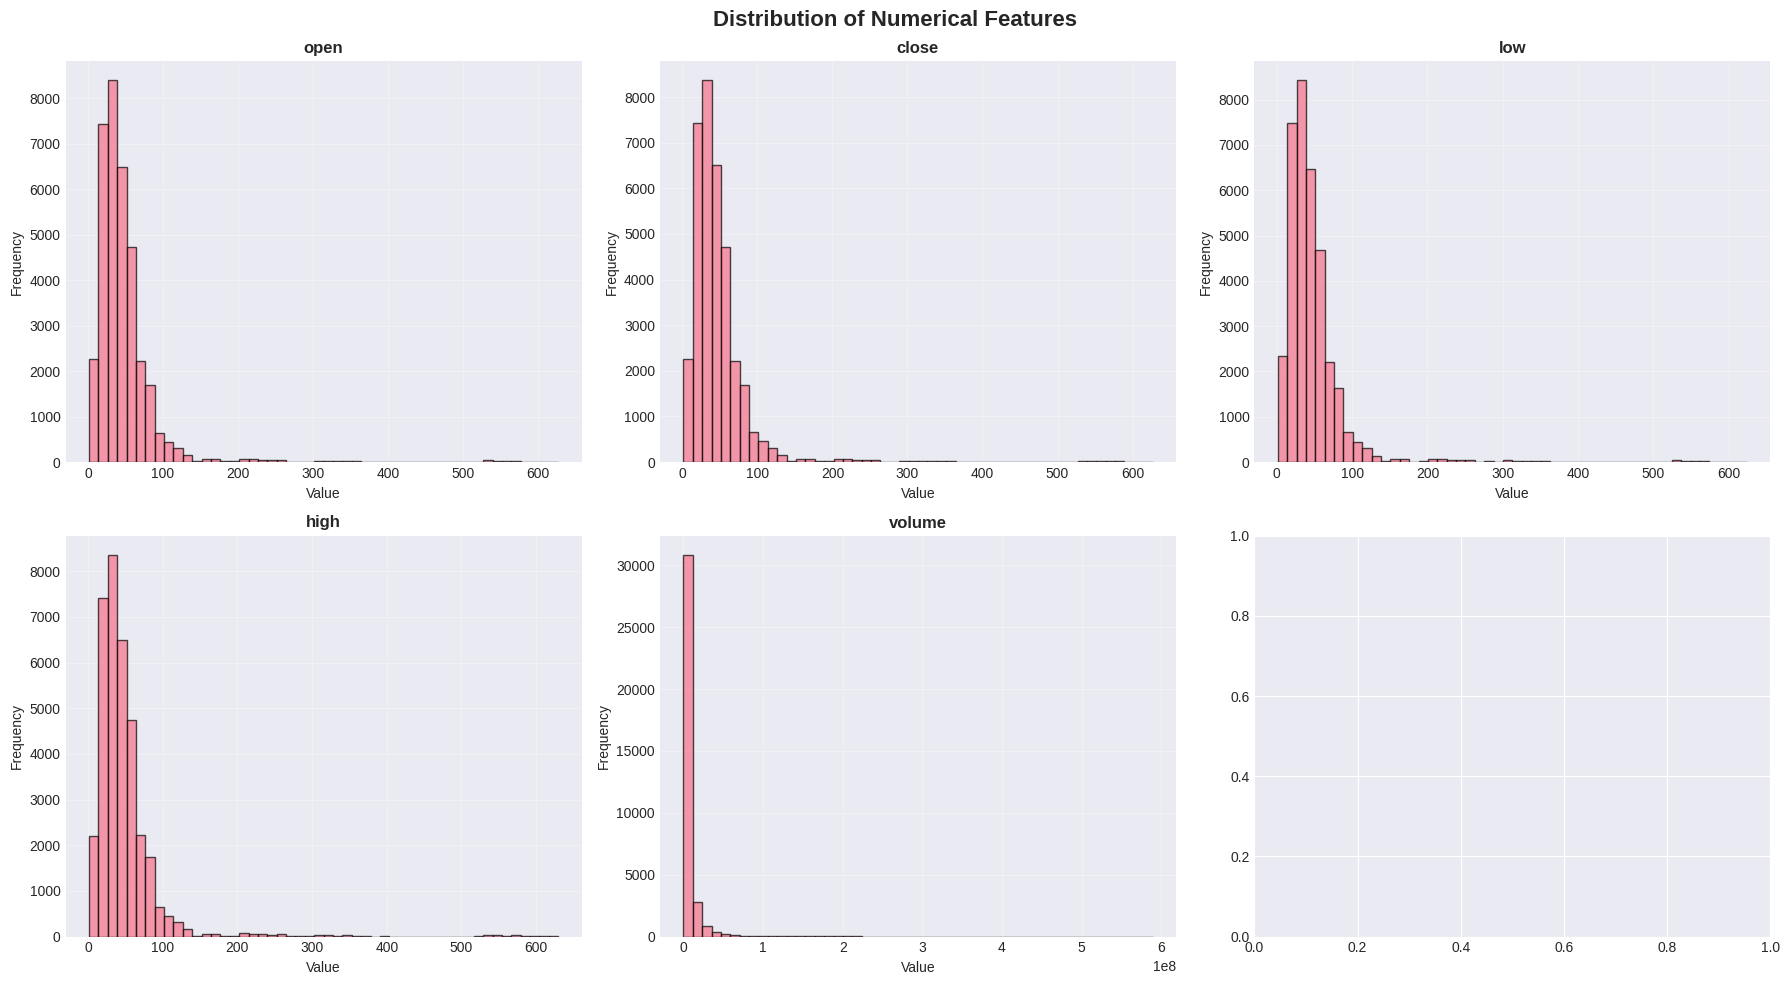

In [8]:
# Distribution of numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Numerical Features', fontsize=16, fontweight='bold')
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:6]):
    axes[idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

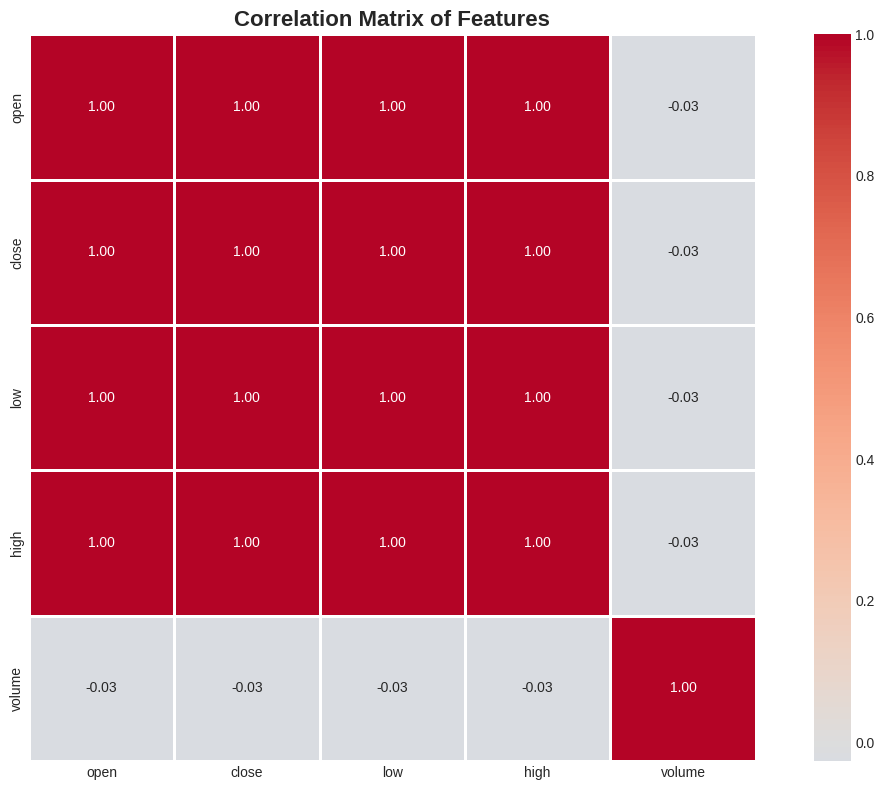


Highly correlated feature pairs (|correlation| > 0.8):
  open <-> close: 1.000
  open <-> low: 1.000
  open <-> high: 1.000
  close <-> low: 1.000
  close <-> high: 1.000
  low <-> high: 1.000


In [9]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nHighly correlated feature pairs (|correlation| > 0.8):")
high_corr = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.8:
            high_corr.append((correlation.columns[i], correlation.columns[j],
                            correlation.iloc[i, j]))

for feat1, feat2, corr_val in high_corr:
    print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")

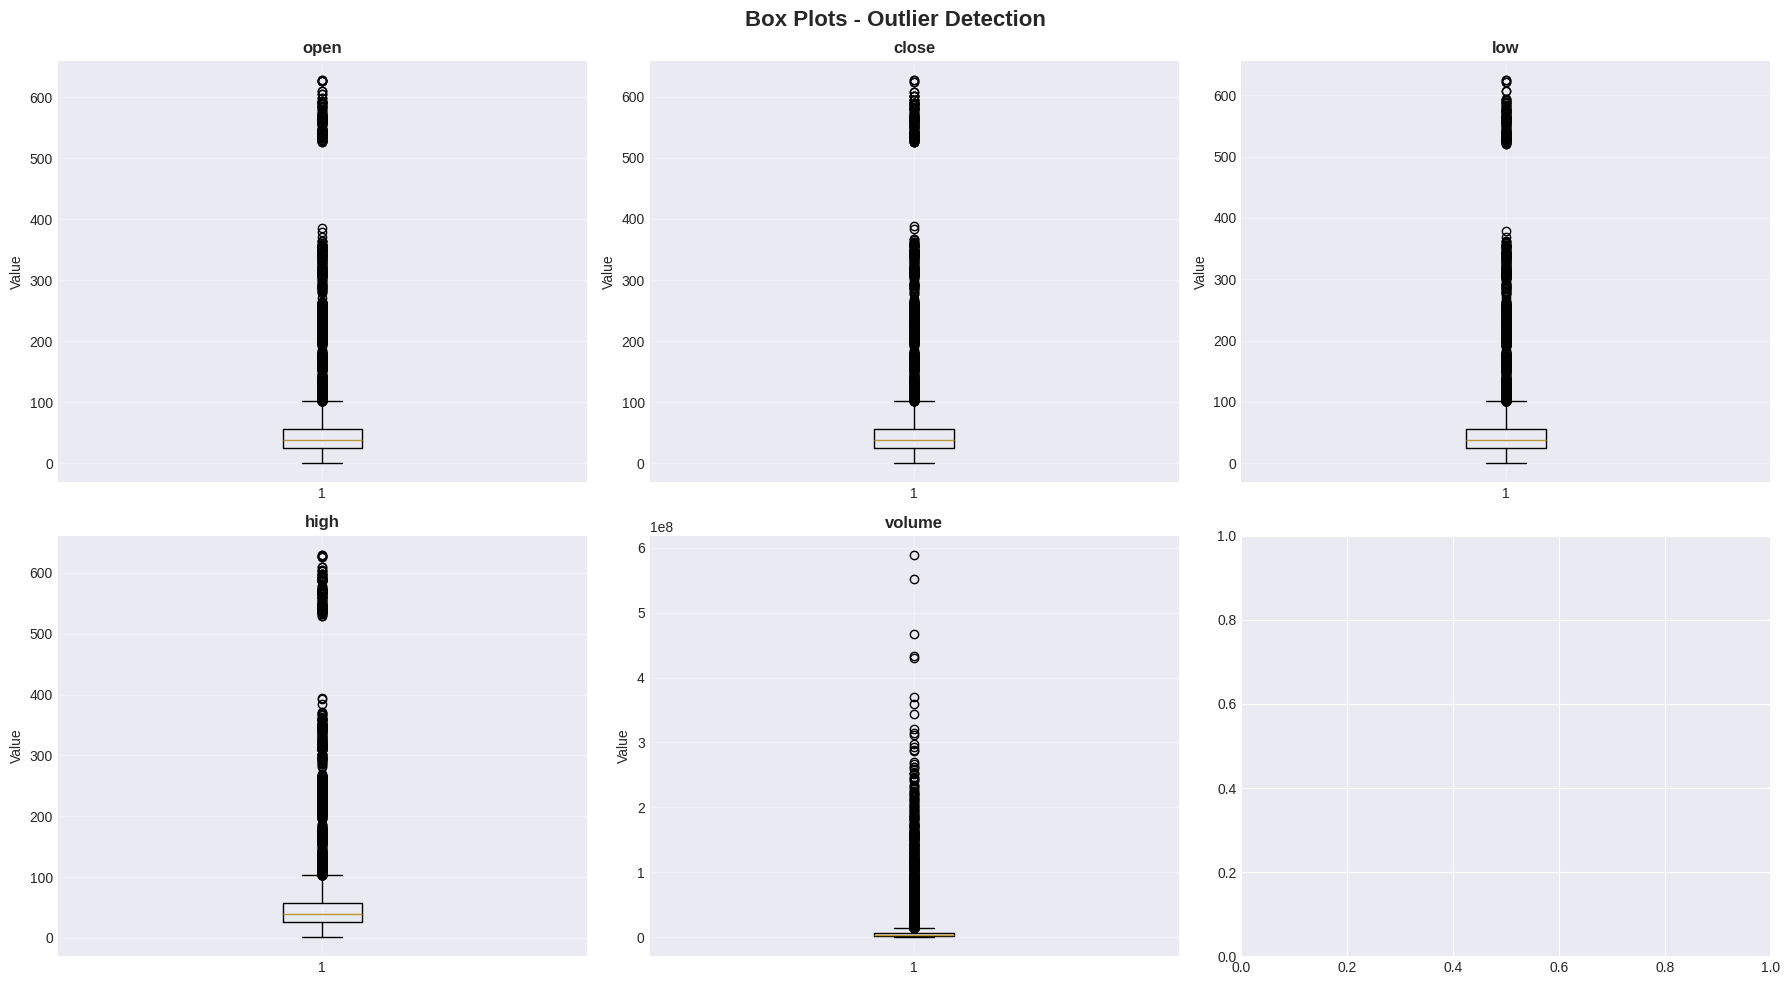

In [10]:
# Box plots to detect outliers
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Box Plots - Outlier Detection', fontsize=16, fontweight='bold')
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:6]):
    axes[idx].boxplot(df[col].dropna(), vert=True)
    axes[idx].set_title(f'{col}', fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

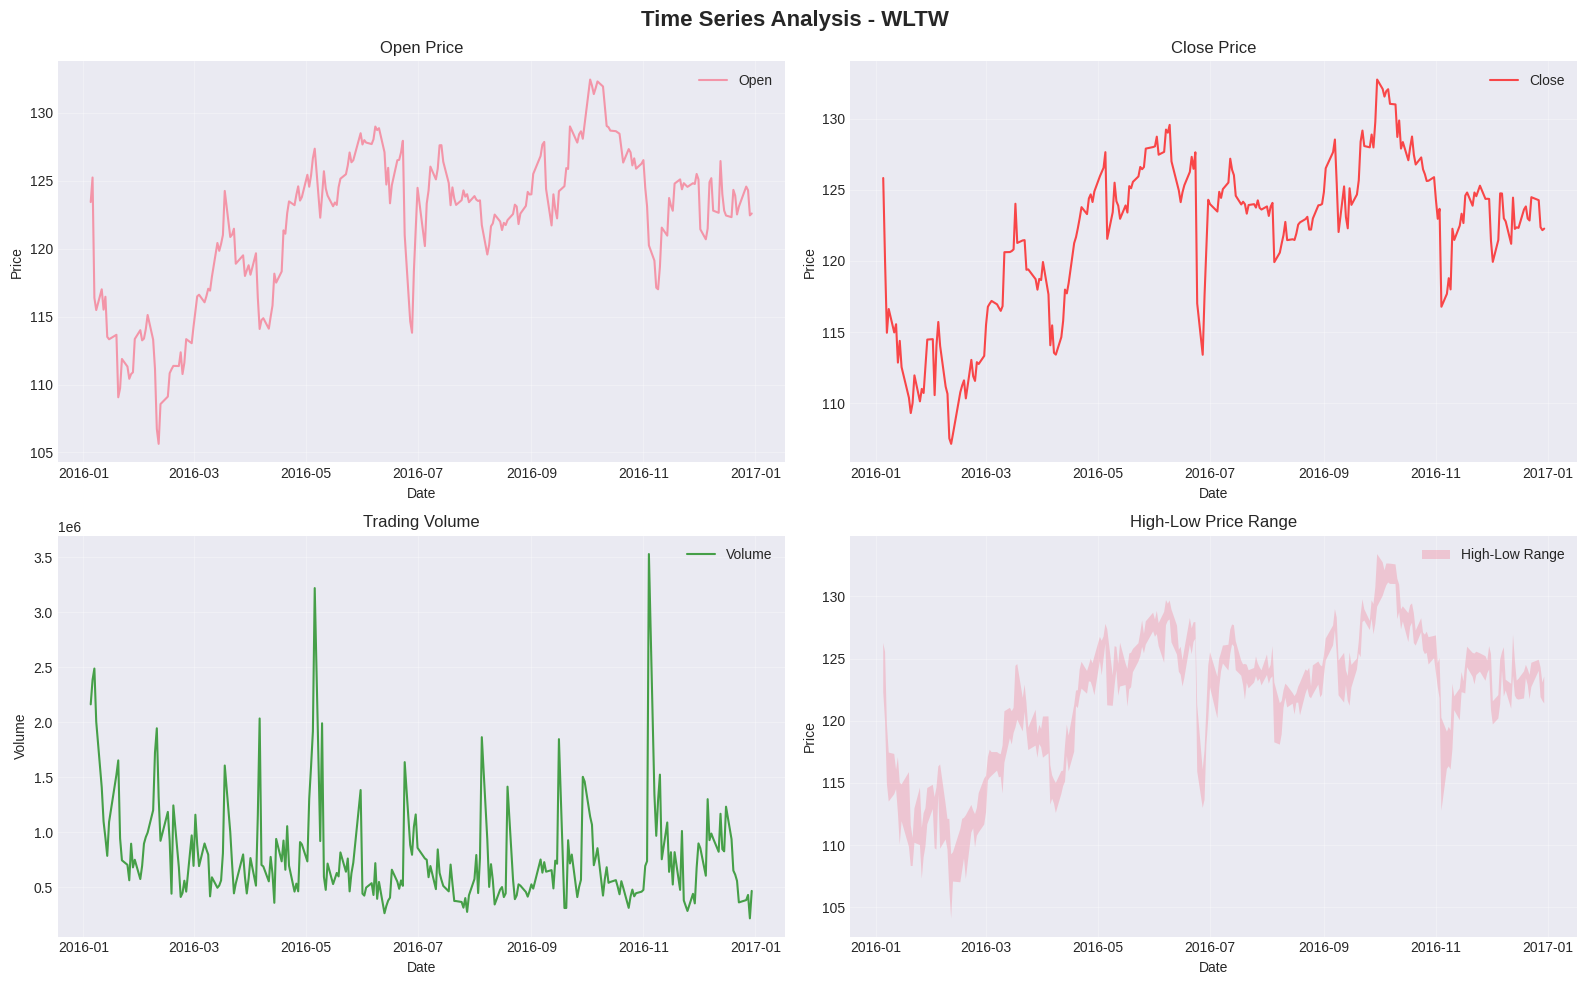


✓ Time series plots created for WLTW
  Number of trading days: 251


In [17]:
# Time series plot (if date column exists)
if 'date' in df.columns:
    # Universal solution: Let pandas infer the format automatically
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True, errors='coerce')
    df_sorted = df.sort_values('date')

    # Plot for a sample symbol
    if 'symbol' in df.columns:
        sample_symbol = df['symbol'].value_counts().index[0]
        df_sample = df_sorted[df_sorted['symbol'] == sample_symbol]

        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle(f'Time Series Analysis - {sample_symbol}',
                    fontsize=16, fontweight='bold')

        axes[0, 0].plot(df_sample['date'], df_sample['open'], label='Open', alpha=0.7)
        axes[0, 0].set_title('Open Price')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        axes[0, 1].plot(df_sample['date'], df_sample['close'],
                       label='Close', color='red', alpha=0.7)
        axes[0, 1].set_title('Close Price')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('Price')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        axes[1, 0].plot(df_sample['date'], df_sample['volume'],
                       label='Volume', color='green', alpha=0.7)
        axes[1, 0].set_title('Trading Volume')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('Volume')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # High-Low range
        axes[1, 1].fill_between(df_sample['date'],
                                df_sample['low'],
                                df_sample['high'],
                                alpha=0.3, label='High-Low Range')
        axes[1, 1].set_title('High-Low Price Range')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Price')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print(f"\n✓ Time series plots created for {sample_symbol}")
        print(f"  Number of trading days: {len(df_sample)}")

---
## 3. Data Preprocessing <a id='3-preprocessing'></a>

We'll prepare the data for training by:
1. Selecting relevant features
2. Handling missing values
3. Creating the target variable
4. Splitting into train/test sets
5. Scaling the features

In [18]:
# Create a copy of the dataframe
df_processed = df.copy()

# Drop non-numeric columns for simplicity (or encode them if needed)
# For this example, we'll focus on numeric features
if 'symbol' in df_processed.columns:
    print(f"Number of unique symbols: {df_processed['symbol'].nunique()}")

if 'date' in df_processed.columns:
    # Extract useful features from date
    df_processed['date'] = pd.to_datetime(df_processed['date'])
    df_processed['year'] = df_processed['date'].dt.year
    df_processed['month'] = df_processed['date'].dt.month
    df_processed['day'] = df_processed['date'].dt.day
    df_processed['day_of_week'] = df_processed['date'].dt.dayofweek

# Drop non-numeric columns
cols_to_drop = df_processed.select_dtypes(include=['object', 'datetime64']).columns
df_processed = df_processed.drop(columns=cols_to_drop)

print("\nProcessed dataset shape:", df_processed.shape)
print("\nColumns:", df_processed.columns.tolist())

Number of unique symbols: 469

Processed dataset shape: (35532, 9)

Columns: ['open', 'close', 'low', 'high', 'volume', 'year', 'month', 'day', 'day_of_week']


In [19]:
# Handle missing values
print("Missing values before handling:")
print(df_processed.isnull().sum())

# Option 1: Drop rows with missing values
df_processed = df_processed.dropna()

# Option 2: Fill with mean/median (uncomment if preferred)
# df_processed = df_processed.fillna(df_processed.mean())

print("\nDataset shape after handling missing values:", df_processed.shape)

Missing values before handling:
open               0
close              0
low                1
high               1
volume             1
year           35206
month          35206
day            35206
day_of_week    35206
dtype: int64

Dataset shape after handling missing values: (326, 9)


In [20]:
# Define features (X) and target (y)
# Let's predict 'close' price based on other features

target_column = 'close'

if target_column not in df_processed.columns:
    print(f"Warning: '{target_column}' not found. Using first numeric column as target.")
    target_column = df_processed.select_dtypes(include=[np.number]).columns[0]

# Features: all columns except target
X = df_processed.drop(columns=[target_column])
y = df_processed[target_column]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"\nFeature names: {X.columns.tolist()}")
print(f"Target name: {target_column}")

Features (X) shape: (326, 8)
Target (y) shape: (326,)

Feature names: ['open', 'low', 'high', 'volume', 'year', 'month', 'day', 'day_of_week']
Target name: close


In [21]:
# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Data Split:")
print(f"  Training set: {X_train.shape[0]} samples ({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"  Test set: {X_test.shape[0]} samples ({(X_test.shape[0]/len(X))*100:.1f}%)")
print(f"  Number of features: {X_train.shape[1]}")

Data Split:
  Training set: 260 samples (79.8%)
  Test set: 66 samples (20.2%)
  Number of features: 8


In [22]:
# Feature Scaling using StandardScaler
# Important: Fit on training data only, then transform both train and test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling Applied:")
print(f"  Mean of training features (before): {X_train.mean().mean():.4f}")
print(f"  Mean of training features (after): {X_train_scaled.mean():.4f}")
print(f"  Std of training features (before): {X_train.std().mean():.4f}")
print(f"  Std of training features (after): {X_train_scaled.std():.4f}")

Feature Scaling Applied:
  Mean of training features (before): 138797.4961
  Mean of training features (after): 0.0000
  Std of training features (before): 98486.1289
  Std of training features (after): 1.0000


In [23]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

print("\nPyTorch Tensors Created:")
print(f"  X_train_tensor shape: {X_train_tensor.shape}")
print(f"  y_train_tensor shape: {y_train_tensor.shape}")
print(f"  X_test_tensor shape: {X_test_tensor.shape}")
print(f"  y_test_tensor shape: {y_test_tensor.shape}")


PyTorch Tensors Created:
  X_train_tensor shape: torch.Size([260, 8])
  y_train_tensor shape: torch.Size([260, 1])
  X_test_tensor shape: torch.Size([66, 8])
  y_test_tensor shape: torch.Size([66, 1])


In [24]:
# Create DataLoader for batch training
batch_size = 64

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created with batch_size={batch_size}")
print(f"  Number of training batches: {len(train_loader)}")
print(f"  Number of test batches: {len(test_loader)}")


DataLoaders created with batch_size=64
  Number of training batches: 5
  Number of test batches: 2


---
## 4. Build Deep Neural Network <a id='4-dnn'></a>

We'll create a flexible DNN architecture using PyTorch.

In [25]:
# Define the Neural Network Architecture
class RegressionDNN(nn.Module):
    """
    Deep Neural Network for Regression

    Parameters:
    -----------
    input_size : int
        Number of input features
    hidden_layers : list
        List of hidden layer sizes [layer1_size, layer2_size, ...]
    dropout_rate : float
        Dropout probability (0 to 1)
    """

    def __init__(self, input_size, hidden_layers=[128, 64, 32], dropout_rate=0.2):
        super(RegressionDNN, self).__init__()

        # Create a list to hold all layers
        layers = []

        # Input layer
        prev_size = input_size

        # Hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Batch normalization
            layers.append(nn.ReLU())  # Activation function
            layers.append(nn.Dropout(dropout_rate))  # Dropout for regularization
            prev_size = hidden_size

        # Output layer (1 neuron for regression)
        layers.append(nn.Linear(prev_size, 1))

        # Combine all layers into Sequential
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Get input size
input_size = X_train_tensor.shape[1]

# Create model instance
model = RegressionDNN(
    input_size=input_size,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.2
)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture:
RegressionDNN(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 11,969


In [26]:
# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss Function: Mean Squared Error (MSE)")
print("Optimizer: Adam")
print(f"Learning Rate: 0.001")

Loss Function: Mean Squared Error (MSE)
Optimizer: Adam
Learning Rate: 0.001


In [27]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device='cpu'):
    """
    Train the model for one epoch
    """
    model.train()  # Set model to training mode
    train_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        optimizer.zero_grad()  # Clear gradients
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_X.size(0)

    return train_loss / len(train_loader.dataset)

# Evaluation function
def evaluate_model(model, test_loader, criterion, device='cpu'):
    """
    Evaluate the model on test data
    """
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    predictions = []
    actuals = []

    with torch.no_grad():  # Disable gradient calculation
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item() * batch_X.size(0)

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(batch_y.cpu().numpy())

    avg_loss = test_loss / len(test_loader.dataset)
    return avg_loss, np.array(predictions), np.array(actuals)

print("Training and evaluation functions defined successfully!")

Training and evaluation functions defined successfully!


In [28]:
# Train the baseline model
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store metrics
train_losses = []
test_losses = []

print(f"Training on {device}...\n")
print("Epoch | Train Loss | Test Loss")
print("-" * 40)

for epoch in range(num_epochs):
    # Train
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Evaluate
    test_loss, _, _ = evaluate_model(model, test_loader, criterion, device)
    test_losses.append(test_loss)

    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f"{epoch+1:5d} | {train_loss:10.4f} | {test_loss:9.4f}")

print("\n✓ Training completed!")

Training on cuda...

Epoch | Train Loss | Test Loss
----------------------------------------
    5 | 11425.8487 | 11469.2679
   10 | 11349.8717 | 11387.1207
   15 | 11270.5989 | 11303.5629
   20 | 11171.8166 | 11186.4710
   25 | 11054.8843 | 11058.0085
   30 | 10904.3490 | 10977.0462
   35 | 10751.2176 | 10834.1905
   40 | 10597.5134 | 10684.5021
   45 | 10390.2617 | 10401.7464
   50 | 10158.8782 | 10361.3040

✓ Training completed!


---
## 5. Hyperparameter Tuning with GridSearch <a id='5-gridsearch'></a>

We'll implement a custom GridSearch to find the best hyperparameters.

In [29]:
# Define hyperparameter grid
param_grid = {
    'hidden_layers': [
        [64, 32],
        [128, 64, 32],
        [256, 128, 64]
    ],
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'sgd']
}

print("Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

# Calculate total combinations
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations to test: {total_combinations}")

Hyperparameter Grid:
  hidden_layers: [[64, 32], [128, 64, 32], [256, 128, 64]]
  learning_rate: [0.001, 0.01]
  dropout_rate: [0.2, 0.3]
  optimizer: ['adam', 'sgd']

Total combinations to test: 24


In [30]:
# Grid Search implementation
from itertools import product

def grid_search(param_grid, X_train, y_train, X_test, y_test,
                num_epochs=30, batch_size=64):
    """
    Perform grid search to find best hyperparameters
    """
    # Create dataloaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_size = X_train.shape[1]

    results = []
    best_score = float('inf')
    best_params = None

    # Generate all combinations
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = [dict(zip(keys, v)) for v in product(*values)]

    print(f"\nStarting Grid Search with {len(combinations)} combinations...\n")

    for idx, params in enumerate(combinations, 1):
        print(f"[{idx}/{len(combinations)}] Testing: {params}")

        # Create model
        model = RegressionDNN(
            input_size=input_size,
            hidden_layers=params['hidden_layers'],
            dropout_rate=params['dropout_rate']
        ).to(device)

        # Create optimizer
        if params['optimizer'] == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        else:
            optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'])

        criterion = nn.MSELoss()

        # Train model
        for epoch in range(num_epochs):
            train_model(model, train_loader, criterion, optimizer, device)

        # Evaluate
        test_loss, _, _ = evaluate_model(model, test_loader, criterion, device)

        results.append({
            'params': params,
            'test_loss': test_loss
        })

        print(f"  → Test Loss: {test_loss:.4f}")

        # Update best
        if test_loss < best_score:
            best_score = test_loss
            best_params = params
            print("  ★ New best model!")

        print()

    return results, best_params, best_score

# Note: Grid search can take a while. For demonstration, we'll use fewer epochs
print("Note: This may take several minutes...")

Note: This may take several minutes...


In [31]:
# Run grid search (uncomment to execute)
# Warning: This will take time depending on your hardware

# results, best_params, best_score = grid_search(
#     param_grid,
#     X_train_tensor,
#     y_train_tensor,
#     X_test_tensor,
#     y_test_tensor,
#     num_epochs=20,
#     batch_size=64
# )

# print("\n" + "="*50)
# print("GRID SEARCH RESULTS")
# print("="*50)
# print(f"\nBest Parameters: {best_params}")
# print(f"Best Test Loss: {best_score:.4f}")

# For demonstration purposes, let's use pre-defined best parameters
best_params = {
    'hidden_layers': [128, 64, 32],
    'learning_rate': 0.001,
    'dropout_rate': 0.2,
    'optimizer': 'adam'
}

print("Using best parameters (for demonstration):")
print(best_params)

Using best parameters (for demonstration):
{'hidden_layers': [128, 64, 32], 'learning_rate': 0.001, 'dropout_rate': 0.2, 'optimizer': 'adam'}


---
## 6. Training and Visualization <a id='6-training'></a>

Train the final model with best parameters and visualize results.

In [32]:
# Create final model with best parameters
final_model = RegressionDNN(
    input_size=input_size,
    hidden_layers=best_params['hidden_layers'],
    dropout_rate=best_params['dropout_rate']
).to(device)

if best_params['optimizer'] == 'adam':
    final_optimizer = optim.Adam(final_model.parameters(),
                                 lr=best_params['learning_rate'])
else:
    final_optimizer = optim.SGD(final_model.parameters(),
                                lr=best_params['learning_rate'])

final_criterion = nn.MSELoss()

print("Final Model Configuration:")
print(final_model)
print(f"\nOptimizer: {best_params['optimizer'].upper()}")
print(f"Learning Rate: {best_params['learning_rate']}")

Final Model Configuration:
RegressionDNN(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Optimizer: ADAM
Learning Rate: 0.001


In [33]:
# Train final model with tracking
num_epochs = 100
final_train_losses = []
final_test_losses = []
final_train_r2 = []
final_test_r2 = []

print(f"Training final model for {num_epochs} epochs...\n")
print("Epoch | Train Loss | Test Loss  | Train R² | Test R²")
print("-" * 60)

for epoch in range(num_epochs):
    # Train
    train_loss = train_model(final_model, train_loader, final_criterion,
                            final_optimizer, device)
    final_train_losses.append(train_loss)

    # Evaluate on training data
    _, train_preds, train_actuals = evaluate_model(final_model, train_loader,
                                                   final_criterion, device)
    train_r2_score = r2_score(train_actuals, train_preds)
    final_train_r2.append(train_r2_score)

    # Evaluate on test data
    test_loss, test_preds, test_actuals = evaluate_model(final_model, test_loader,
                                                         final_criterion, device)
    final_test_losses.append(test_loss)
    test_r2_score = r2_score(test_actuals, test_preds)
    final_test_r2.append(test_r2_score)

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"{epoch+1:5d} | {train_loss:10.4f} | {test_loss:10.4f} | "
              f"{train_r2_score:8.4f} | {test_r2_score:7.4f}")

print("\n✓ Training completed!")

Training final model for 100 epochs...

Epoch | Train Loss | Test Loss  | Train R² | Test R²
------------------------------------------------------------
   10 | 11355.4728 | 11391.1043 |  -4.7667 | -4.9027
   20 | 11191.9639 | 11203.7229 |  -4.6715 | -4.8056
   30 | 10980.2875 | 10909.2278 |  -4.5195 | -4.6530
   40 | 10712.4150 | 10755.1731 |  -4.4429 | -4.5732
   50 | 10366.2084 | 10271.2004 |  -4.1959 | -4.3224
   60 |  9824.6904 |  9637.5545 |  -3.8800 | -3.9940
   70 |  9229.2461 |  9177.7325 |  -3.6441 | -3.7557
   80 |  8557.8403 |  8511.7409 |  -3.3039 | -3.4106
   90 |  7745.5551 |  7704.0804 |  -2.8811 | -2.9921
  100 |  7050.6812 |  6839.5502 |  -2.4384 | -2.5441

✓ Training completed!


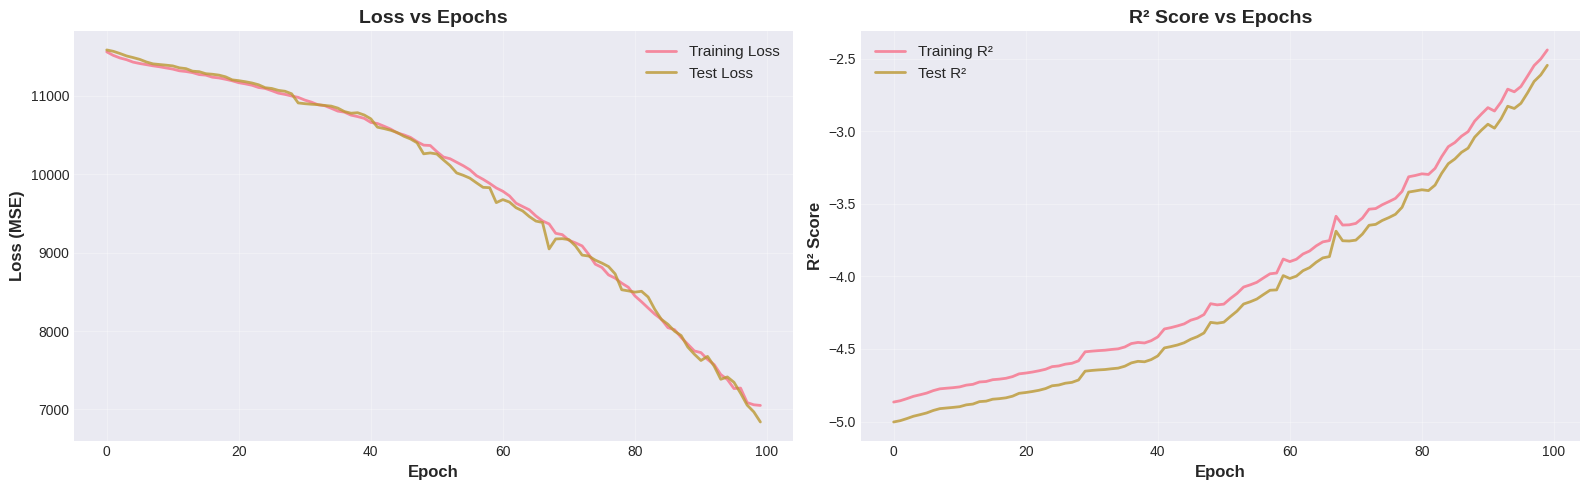


Final Metrics:
  Training Loss: 7050.6812
  Test Loss: 6839.5502
  Training R²: -2.4384
  Test R²: -2.5441


In [34]:
# Visualization: Loss vs Epochs
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Loss vs Epochs
axes[0].plot(final_train_losses, label='Training Loss', linewidth=2, alpha=0.8)
axes[0].plot(final_test_losses, label='Test Loss', linewidth=2, alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Loss vs Epochs', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: R² Score vs Epochs
axes[1].plot(final_train_r2, label='Training R²', linewidth=2, alpha=0.8)
axes[1].plot(final_test_r2, label='Test R²', linewidth=2, alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1].set_title('R² Score vs Epochs', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Metrics:")
print(f"  Training Loss: {final_train_losses[-1]:.4f}")
print(f"  Test Loss: {final_test_losses[-1]:.4f}")
print(f"  Training R²: {final_train_r2[-1]:.4f}")
print(f"  Test R²: {final_test_r2[-1]:.4f}")

In [35]:
# Additional metrics
_, final_train_preds, final_train_actuals = evaluate_model(
    final_model, train_loader, final_criterion, device
)
_, final_test_preds, final_test_actuals = evaluate_model(
    final_model, test_loader, final_criterion, device
)

# Calculate metrics
train_mse = mean_squared_error(final_train_actuals, final_train_preds)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(final_train_actuals, final_train_preds)
train_r2 = r2_score(final_train_actuals, final_train_preds)

test_mse = mean_squared_error(final_test_actuals, final_test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(final_test_actuals, final_test_preds)
test_r2 = r2_score(final_test_actuals, final_test_preds)

print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION METRICS")
print("="*60)
print("\nTraining Set:")
print(f"  MSE (Mean Squared Error):     {train_mse:.4f}")
print(f"  RMSE (Root Mean Squared Error): {train_rmse:.4f}")
print(f"  MAE (Mean Absolute Error):    {train_mae:.4f}")
print(f"  R² Score:                     {train_r2:.4f}")

print("\nTest Set:")
print(f"  MSE (Mean Squared Error):     {test_mse:.4f}")
print(f"  RMSE (Root Mean Squared Error): {test_rmse:.4f}")
print(f"  MAE (Mean Absolute Error):    {test_mae:.4f}")
print(f"  R² Score:                     {test_r2:.4f}")
print("\n" + "="*60)


COMPREHENSIVE EVALUATION METRICS

Training Set:
  MSE (Mean Squared Error):     6768.9038
  RMSE (Root Mean Squared Error): 82.2733
  MAE (Mean Absolute Error):    75.6008
  R² Score:                     -2.4384

Test Set:
  MSE (Mean Squared Error):     6839.5503
  RMSE (Root Mean Squared Error): 82.7016
  MAE (Mean Absolute Error):    76.1331
  R² Score:                     -2.5441



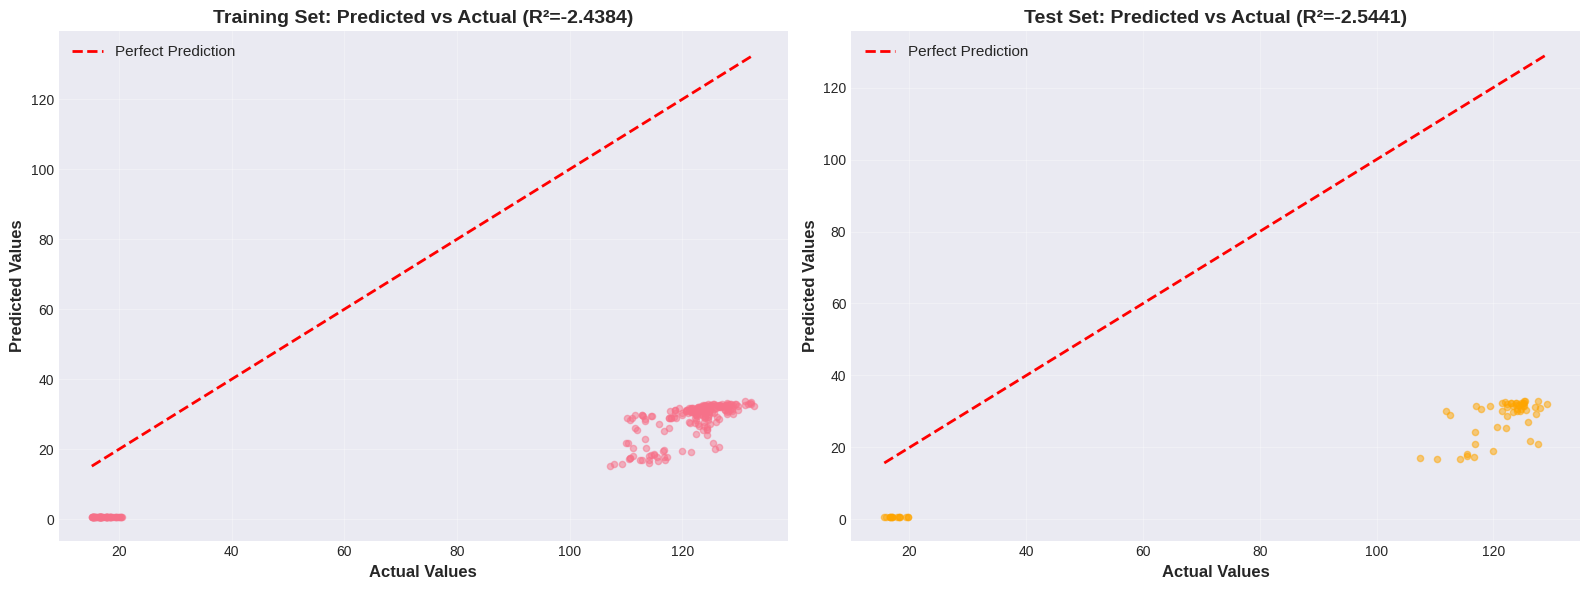

In [36]:
# Scatter plot: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training data
axes[0].scatter(final_train_actuals, final_train_preds, alpha=0.5, s=20)
axes[0].plot([final_train_actuals.min(), final_train_actuals.max()],
            [final_train_actuals.min(), final_train_actuals.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0].set_title(f'Training Set: Predicted vs Actual (R²={train_r2:.4f})',
                 fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Test data
axes[1].scatter(final_test_actuals, final_test_preds, alpha=0.5, s=20, color='orange')
axes[1].plot([final_test_actuals.min(), final_test_actuals.max()],
            [final_test_actuals.min(), final_test_actuals.max()],
            'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Values', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Values', fontsize=12, fontweight='bold')
axes[1].set_title(f'Test Set: Predicted vs Actual (R²={test_r2:.4f})',
                 fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

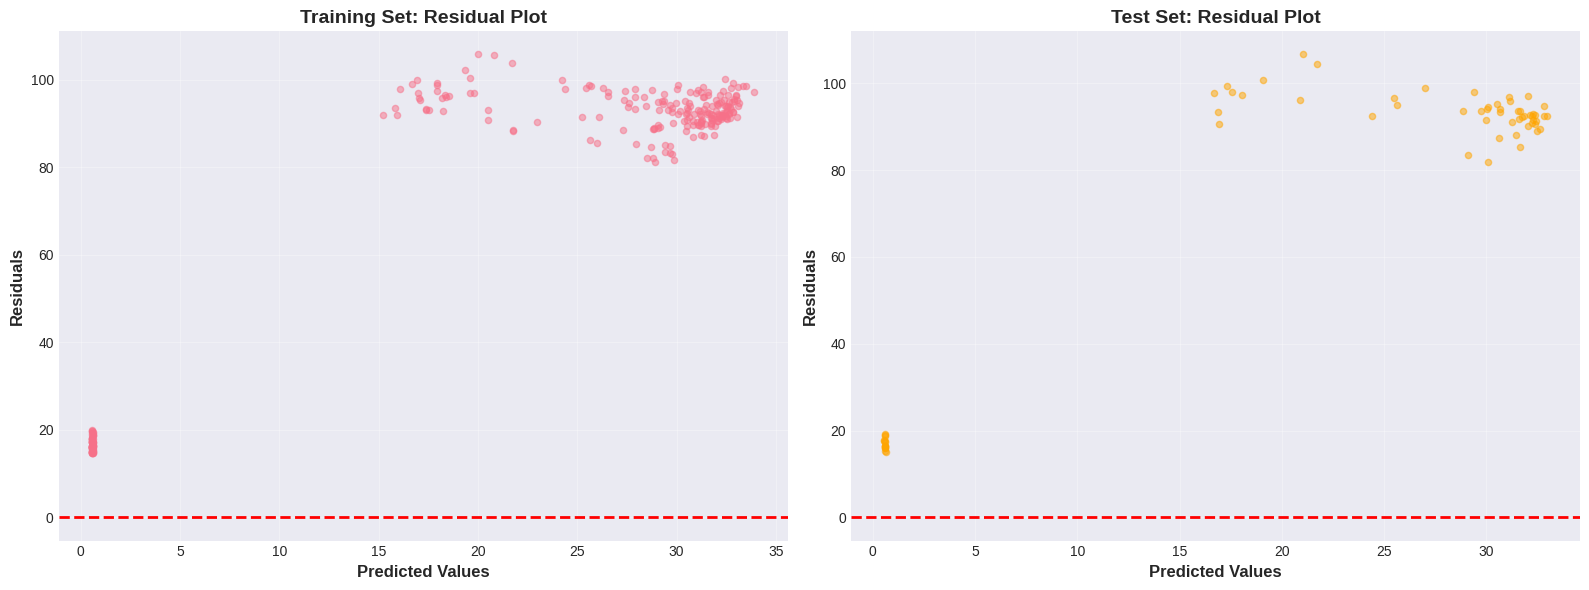


✓ Residual plots created successfully!
Training residuals - Mean: 75.6008, Std: 32.4564
Test residuals - Mean: 76.1331, Std: 32.3002


In [38]:
# Residual plot
# Fix: Ensure all arrays are 1D and same shape
train_residuals = final_train_actuals.flatten() - final_train_preds.flatten()
test_residuals = final_test_actuals.flatten() - final_test_preds.flatten()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training residuals
axes[0].scatter(final_train_preds.flatten(), train_residuals, alpha=0.5, s=20)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[0].set_title('Training Set: Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Test residuals
axes[1].scatter(final_test_preds.flatten(), test_residuals, alpha=0.5, s=20, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Values', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals', fontsize=12, fontweight='bold')
axes[1].set_title('Test Set: Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Residual plots created successfully!")
print(f"Training residuals - Mean: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}")
print(f"Test residuals - Mean: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f}")

### Interpretation of Results

**Loss vs Epochs:**
- Both training and test loss should decrease over epochs
- If training loss decreases but test loss increases → **Overfitting**
- If both remain high → **Underfitting**
- If both decrease similarly → **Good fit**

**R² Score:**
- Ranges from -∞ to 1 (1 is perfect)
- R² > 0.7 is generally considered good
- Training R² >> Test R² suggests overfitting

**Predicted vs Actual Plot:**
- Points close to the red line indicate good predictions
- Systematic deviation suggests model bias

**Residual Plot:**
- Should show random scatter around y=0
- Patterns suggest model is missing something

---
## 7. Regularization Techniques <a id='7-regularization'></a>

Let's apply various regularization techniques and compare results.

In [39]:
# Model with L2 Regularization (Weight Decay)
class RegressionDNN_L2(nn.Module):
    """
    DNN with L2 regularization via weight decay in optimizer
    """
    def __init__(self, input_size, hidden_layers=[128, 64, 32], dropout_rate=0.2):
        super(RegressionDNN_L2, self).__init__()
        layers = []
        prev_size = input_size

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Train with L2 regularization
model_l2 = RegressionDNN_L2(
    input_size=input_size,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.3  # Increased dropout
).to(device)

# Optimizer with weight decay (L2 regularization)
optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.001, weight_decay=0.01)
criterion_l2 = nn.MSELoss()

print("Model with L2 Regularization (weight_decay=0.01, dropout=0.3):")
print(f"Total parameters: {sum(p.numel() for p in model_l2.parameters()):,}")

Model with L2 Regularization (weight_decay=0.01, dropout=0.3):
Total parameters: 11,969


In [40]:
# Train L2 model
num_epochs_reg = 100
l2_train_losses = []
l2_test_losses = []
l2_train_r2 = []
l2_test_r2 = []

print(f"Training L2 regularized model...\n")

for epoch in range(num_epochs_reg):
    train_loss = train_model(model_l2, train_loader, criterion_l2, optimizer_l2, device)
    l2_train_losses.append(train_loss)

    _, train_preds, train_actuals = evaluate_model(model_l2, train_loader, criterion_l2, device)
    l2_train_r2.append(r2_score(train_actuals, train_preds))

    test_loss, test_preds, test_actuals = evaluate_model(model_l2, test_loader, criterion_l2, device)
    l2_test_losses.append(test_loss)
    l2_test_r2.append(r2_score(test_actuals, test_preds))

print("✓ L2 model training completed!")

Training L2 regularized model...

✓ L2 model training completed!


In [41]:
# Model with Early Stopping
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve
    """
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            self.counter = 0

# Train with early stopping
model_es = RegressionDNN(
    input_size=input_size,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.2
).to(device)

optimizer_es = optim.Adam(model_es.parameters(), lr=0.001)
criterion_es = nn.MSELoss()
early_stopping = EarlyStopping(patience=15)

es_train_losses = []
es_test_losses = []
es_train_r2 = []
es_test_r2 = []

print("Training with Early Stopping (patience=15)...\n")

for epoch in range(200):  # Max epochs
    train_loss = train_model(model_es, train_loader, criterion_es, optimizer_es, device)
    es_train_losses.append(train_loss)

    _, train_preds, train_actuals = evaluate_model(model_es, train_loader, criterion_es, device)
    es_train_r2.append(r2_score(train_actuals, train_preds))

    test_loss, test_preds, test_actuals = evaluate_model(model_es, test_loader, criterion_es, device)
    es_test_losses.append(test_loss)
    es_test_r2.append(r2_score(test_actuals, test_preds))

    early_stopping(test_loss, model_es)

    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        model_es.load_state_dict(early_stopping.best_model)
        break

print("✓ Early stopping model training completed!")

Training with Early Stopping (patience=15)...

✓ Early stopping model training completed!


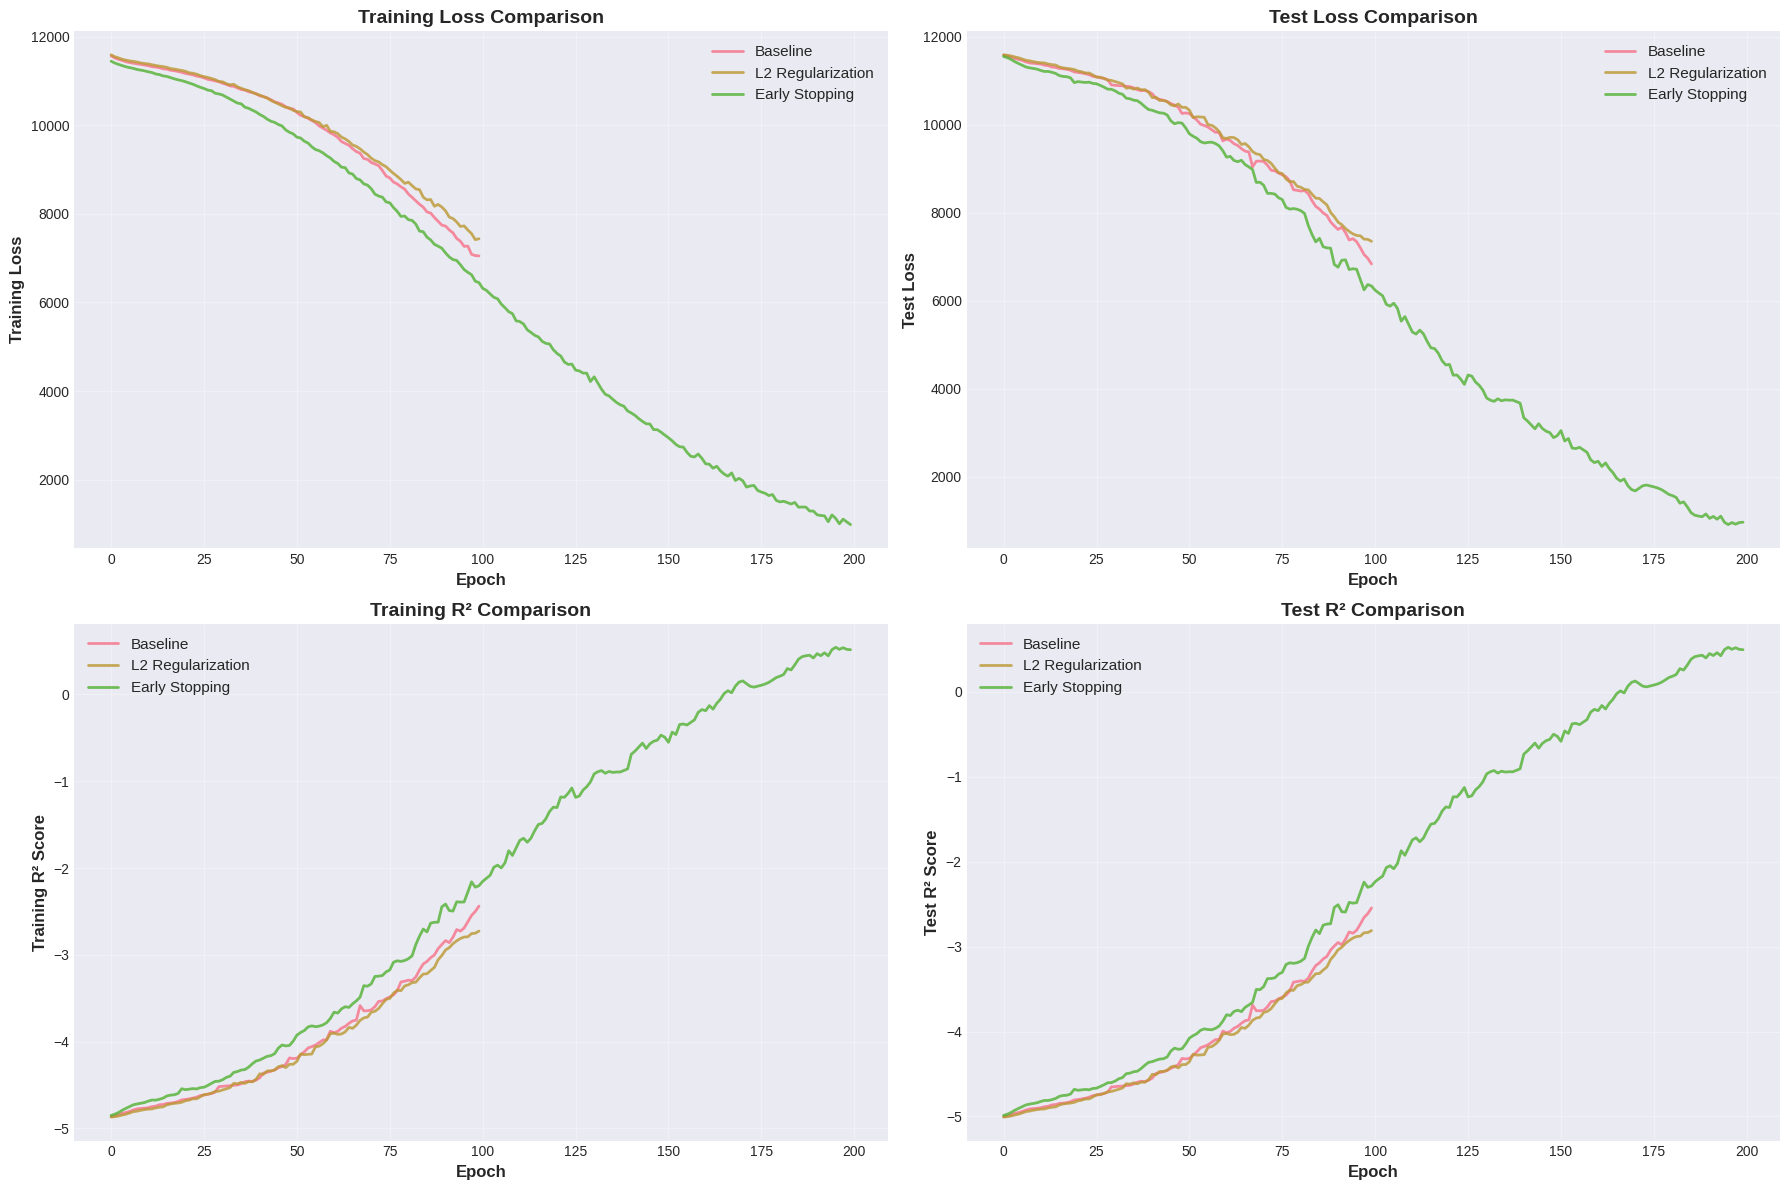

In [42]:
# Compare all models
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Training Loss Comparison
axes[0, 0].plot(final_train_losses, label='Baseline', linewidth=2, alpha=0.8)
axes[0, 0].plot(l2_train_losses, label='L2 Regularization', linewidth=2, alpha=0.8)
axes[0, 0].plot(es_train_losses, label='Early Stopping', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Training Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Test Loss Comparison
axes[0, 1].plot(final_test_losses, label='Baseline', linewidth=2, alpha=0.8)
axes[0, 1].plot(l2_test_losses, label='L2 Regularization', linewidth=2, alpha=0.8)
axes[0, 1].plot(es_test_losses, label='Early Stopping', linewidth=2, alpha=0.8)
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Test Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Training R² Comparison
axes[1, 0].plot(final_train_r2, label='Baseline', linewidth=2, alpha=0.8)
axes[1, 0].plot(l2_train_r2, label='L2 Regularization', linewidth=2, alpha=0.8)
axes[1, 0].plot(es_train_r2, label='Early Stopping', linewidth=2, alpha=0.8)
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Training R² Score', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Training R² Comparison', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Test R² Comparison
axes[1, 1].plot(final_test_r2, label='Baseline', linewidth=2, alpha=0.8)
axes[1, 1].plot(l2_test_r2, label='L2 Regularization', linewidth=2, alpha=0.8)
axes[1, 1].plot(es_test_r2, label='Early Stopping', linewidth=2, alpha=0.8)
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Test R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Test R² Comparison', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [43]:
# Get final metrics for all models
_, l2_final_test_preds, l2_final_test_actuals = evaluate_model(
    model_l2, test_loader, criterion_l2, device
)
_, es_final_test_preds, es_final_test_actuals = evaluate_model(
    model_es, test_loader, criterion_es, device
)

# Create comparison table
comparison_data = {
    'Model': ['Baseline', 'L2 Regularization', 'Early Stopping'],
    'Test MSE': [
        mean_squared_error(final_test_actuals, final_test_preds),
        mean_squared_error(l2_final_test_actuals, l2_final_test_preds),
        mean_squared_error(es_final_test_actuals, es_final_test_preds)
    ],
    'Test RMSE': [
        np.sqrt(mean_squared_error(final_test_actuals, final_test_preds)),
        np.sqrt(mean_squared_error(l2_final_test_actuals, l2_final_test_preds)),
        np.sqrt(mean_squared_error(es_final_test_actuals, es_final_test_preds))
    ],
    'Test MAE': [
        mean_absolute_error(final_test_actuals, final_test_preds),
        mean_absolute_error(l2_final_test_actuals, l2_final_test_preds),
        mean_absolute_error(es_final_test_actuals, es_final_test_preds)
    ],
    'Test R²': [
        r2_score(final_test_actuals, final_test_preds),
        r2_score(l2_final_test_actuals, l2_final_test_preds),
        r2_score(es_final_test_actuals, es_final_test_preds)
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
display(comparison_df)

# Find best model
best_idx = comparison_df['Test R²'].idxmax()
print(f"\n★ Best Model: {comparison_df.loc[best_idx, 'Model']}")
print(f"  Test R²: {comparison_df.loc[best_idx, 'Test R²']:.4f}")
print(f"  Test RMSE: {comparison_df.loc[best_idx, 'Test RMSE']:.4f}")


MODEL COMPARISON


,Model,Test MSE,Test RMSE,Test MAE,Test R²
0,Baseline,6839.550293,82.701574,76.133110,-2.544142
1,L2 Regularization,7354.451660,85.758100,78.622551,-2.810955
2,Early Stopping,969.088440,31.130185,30.157343,0.497834



★ Best Model: Early Stopping
  Test R²: 0.4978
  Test RMSE: 31.1302


---
## 8. Conclusions and Summary <a id='8-conclusions'></a>

### Key Takeaways:

1. **Data Preprocessing is Critical**
   - Proper scaling improves model convergence
   - Handling missing values prevents errors
   - Feature selection affects performance

2. **Model Architecture Matters**
   - Deeper networks can learn complex patterns
   - Too deep → overfitting risk
   - Batch normalization helps stabilize training

3. **Hyperparameter Tuning**
   - Learning rate affects convergence speed
   - Different optimizers work better for different problems
   - Grid search helps find optimal parameters

4. **Regularization Prevents Overfitting**
   - Dropout randomly disables neurons
   - L2 regularization penalizes large weights
   - Early stopping prevents overtraining

5. **Evaluation Metrics**
   - MSE/RMSE for absolute error magnitude
   - MAE for average error
   - R² for explained variance (closer to 1 is better)

### What I Learned:

- How to build neural networks in PyTorch
- The importance of data preprocessing
- How to implement and compare different regularization techniques
- Interpreting training curves to detect overfitting/underfitting
- Using proper evaluation metrics for regression tasks

### Next Steps:

1. Experiment with different architectures
2. Try advanced regularization (L1, elastic net)
3. Implement learning rate scheduling
4. Explore ensemble methods
5. Apply to other regression datasets

In [44]:
# Save the best model
torch.save(final_model.state_dict(), 'best_regression_model.pth')
print("✓ Model saved as 'best_regression_model.pth'")

# Save scaler for future predictions
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler saved as 'scaler.pkl'")

✓ Model saved as 'best_regression_model.pth'
✓ Scaler saved as 'scaler.pkl'


---
## END OF PART 1

This completes the regression task. Next, we'll work on Part 2: Multi-Class Classification.

**Created by:** SAHTOUT Rahma  
**Date:** November 2025  
**Course:** Deep Learning - Master SITBD  
**Instructor:** Pr. ELAACHAK LOTFI